# Visualization with Polarplot

Example of how to use Polarplot to visualize data (Figure 5 in paper). Polarplot is useful for showing data in a polar coordinate system, and takes coordinates in magnetic latitude and magnetic local time (MLT). The polarplot axis gives a top down view of the northern hemsiphere.

Figure panels:

A) Figure with CS grid on polar coordinates

B) Figure with equal area grid

C) Figure with data - to be explained below

Import relevant modules:

In [1]:
%matplotlib inline
import lompe
import apexpy
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
#from matplotlib import rc
#rc('font', **{'family': 'sans-serif'})

Re = 6371.2e3    # Earth radius
HI = 110e3       # Ionospheric altitude
time = dt.datetime(2005, 9, 10)

# TODO: update this when polplot is included in Lompe
from polplot import Polarplot

Make a cubed sphere grid - for illustration purposes, the grid is quite coarse.

In [2]:
L, W, Lres, Wres = 5000e3, 5000e3, 200e3, 200e3 # m
position = (-88, 72) # geographic lon, lat of center of grid
orientation = 45     # angle defining orientation of xi-axis
projection = lompe.cs.CSprojection(position, orientation)
grid = lompe.cs.CSgrid(projection, L, W, Lres, Wres, R = Re+HI) # set grid to ionospheric altitude

Then we show how to plot different types of data on the grids:

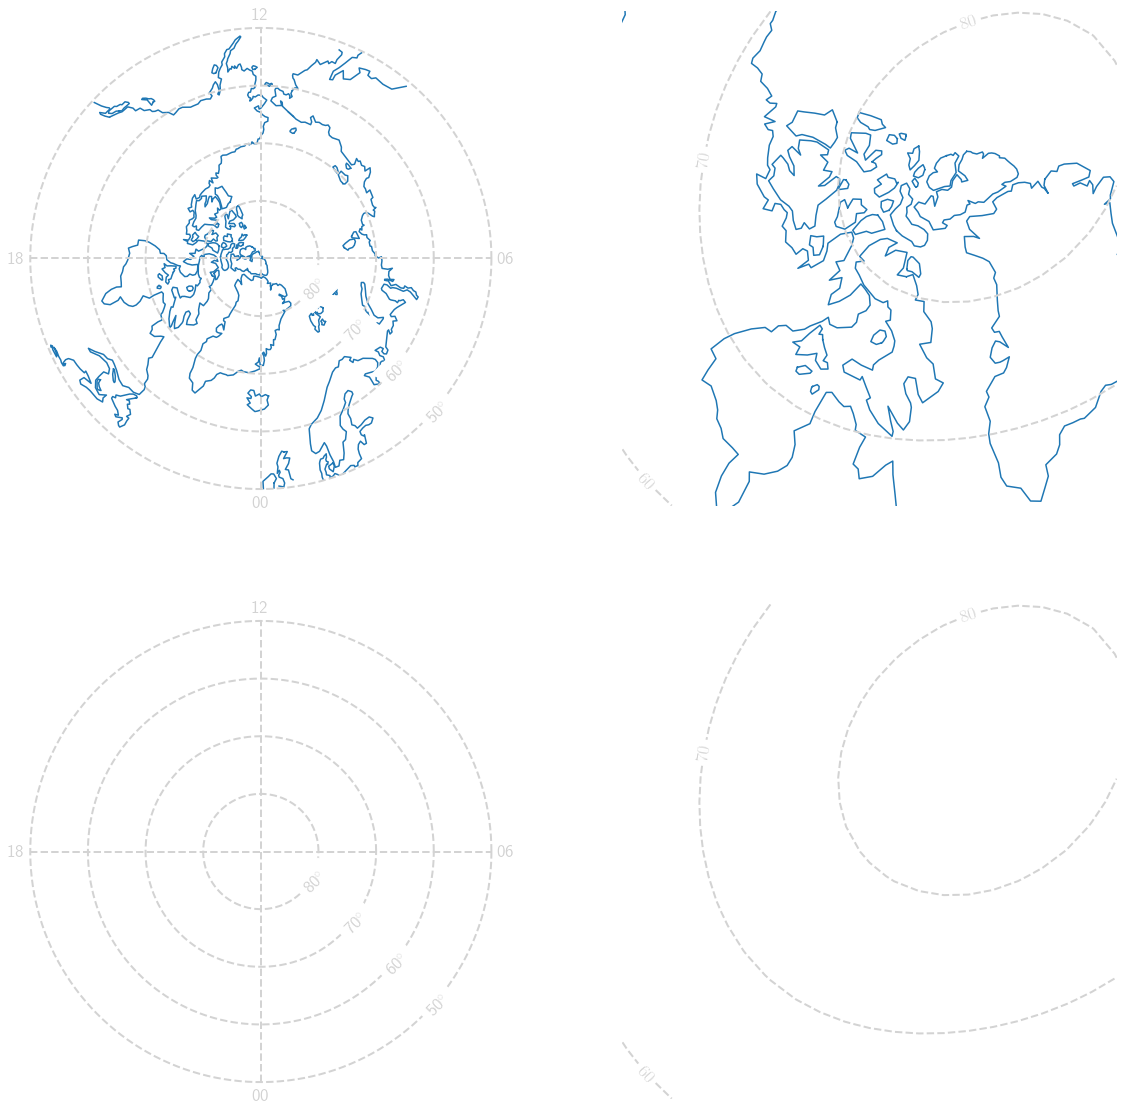

In [3]:
# Start by setting up figure and subplots:
fig = plt.figure(figsize = (20,20))
axs = {}

axs['polar' ] = fig.add_subplot(221)
axs['grid'  ] = fig.add_subplot(222)
axs['polar2'] = fig.add_subplot(223)
axs['grid2' ] = fig.add_subplot(224)

# remove borders from axes and set aspect ratio
for key in axs.keys():
    axs[key].set_axis_off()
    axs[key].set_aspect('equal')

# polar axes with MLT labels
pax  = Polarplot(axs['polar' ], minlat=50, plotgrid=True, linewidth=2)
pax2 = Polarplot(axs['polar2'], minlat=50, plotgrid=True, linewidth=2)
pax. writeMLTlabels( mlat=49, fontsize=18, color='lightgrey')
pax2.writeMLTlabels( mlat=49, fontsize=18, color='lightgrey')
pax. writeMLATlabels(mlt=3, fontsize=18)
pax2.writeMLATlabels(mlt=3, fontsize=18)

# TODO: fix altitudes for apex
# magnetic latitude contours on xi, eta axes
apex = apexpy.Apex(time, refh=HI*1e-3)
mlat, _ = apex.geo2apex(grid.lat, grid.lon, height = HI*1e-3)
latlevels = np.r_[-80:81:10]
co  = axs['grid' ].contour(grid.xi, grid.eta, mlat, linestyles = '--', colors='lightgrey', linewidths=2, levels=latlevels)
co2 = axs['grid2'].contour(grid.xi, grid.eta, mlat, linestyles = '--', colors='lightgrey', linewidths=2, levels=latlevels)
axs['grid' ].clabel(co,  co.levels, inline = True, fontsize=18)
axs['grid2'].clabel(co2, co.levels, inline = True, fontsize=18)

# adjust limits of xi, eta axes
xlim, ylim = axs['grid'].get_xlim(), axs['grid'].get_ylim()
axs['grid' ].set_xlim(xlim)
axs['grid' ].set_ylim(ylim)
axs['grid2'].set_xlim(xlim)
axs['grid2'].set_ylim(ylim)

# coastlines on polar axis
map_kwargs = {'resolution':'110m', 'category':'physical', 'name':'coastline'}
plot_kwargs = {'color':'C0', 'zorder':1}
pax.coastlines(time, map_kwargs=map_kwargs, plot_kwargs=plot_kwargs)

# coastlines on grid axis
for cl in grid.projection.get_projected_coastlines(**map_kwargs):
    axs['grid' ].plot(cl[0], cl[1], **plot_kwargs)
  

#### Plot

We plot the cubed sphere grid on the polar axis to show how plot works.

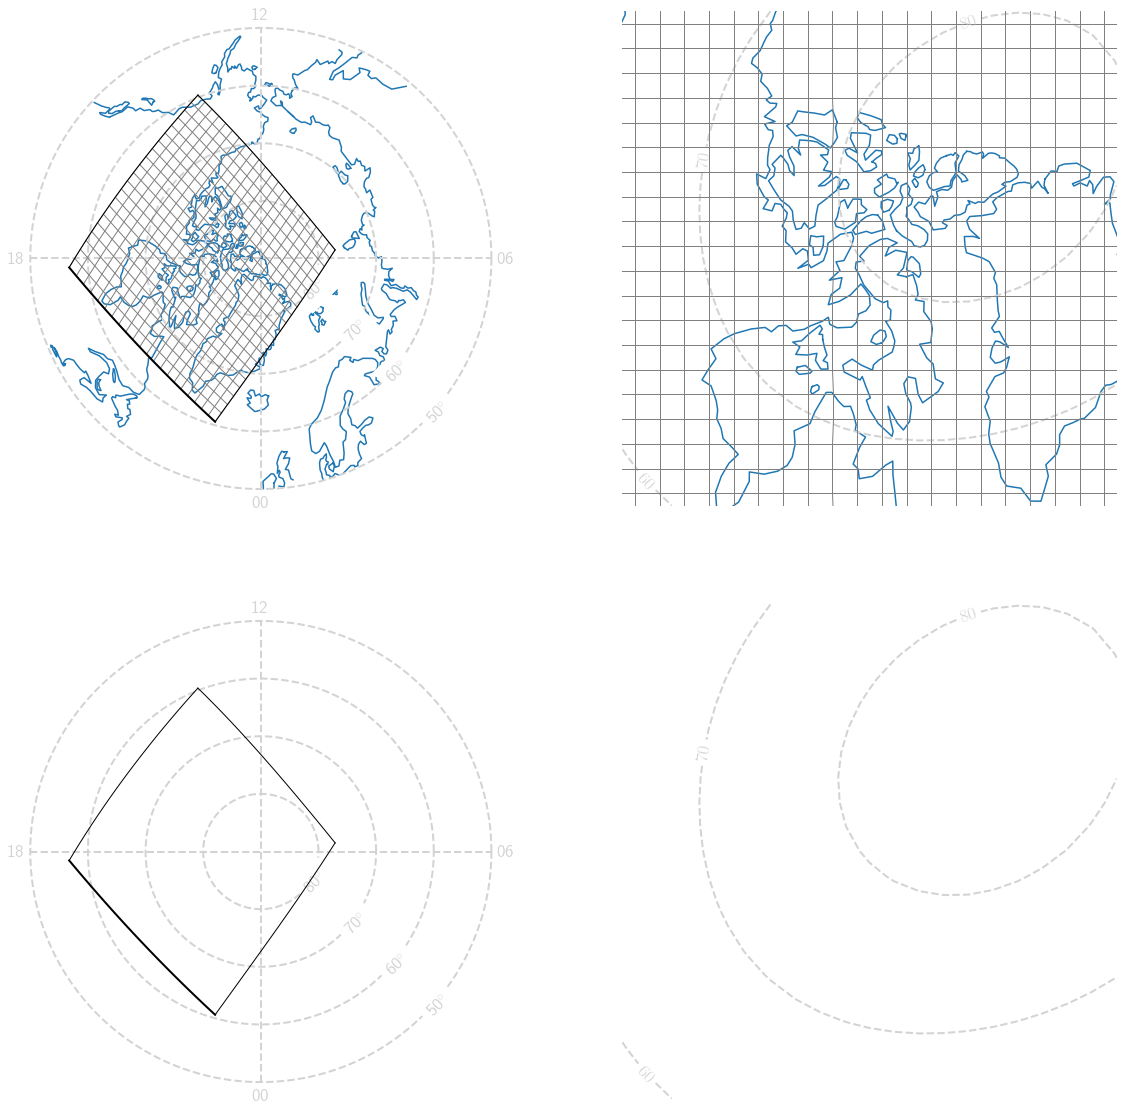

In [4]:
# on polar axis
for lon, lat in grid.get_grid_boundaries():
    mlat, mlon = apex.geo2apex(lat, lon, height=HI*1e-3)
    mlt = apex.mlon2mlt(mlon, time)
    pax.plot(mlat, mlt, color = 'grey', linewidth = 1)
    
# grid outline
xs = (grid.lon_mesh[0, :], grid.lon_mesh[-1, :], grid.lon_mesh[:, 0], grid.lon_mesh[:, -1])
ys = (grid.lat_mesh[0, :], grid.lat_mesh[-1, :], grid.lat_mesh[:, 0], grid.lat_mesh[:, -1])
for i, c in enumerate(zip(xs, ys)):
    lon, lat = c
    mlat, mlon = apex.geo2apex(lat, lon, 110)
    mlt = apex.mlon2mlt(mlon, time)
    pax.plot( mlat, mlt, color = 'black', linewidth = 2 if i == 0 else 1, zorder = 2) # like plt.plot
    pax2.plot(mlat, mlt, color = 'black', linewidth = 2 if i == 0 else 1, zorder = 2)

# on xi, eta axis
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    axs['grid'].plot(xi, eta, color = 'grey', lw = 1)

fig

#### Scatter and text

We illustrate how the scatter and text methods work for polplot by marking the Geographic North Pole on the axis. Note that it is offset from the magnetic pole. It will also move as the Earth rotates below the magnetic latitude, MLT system.

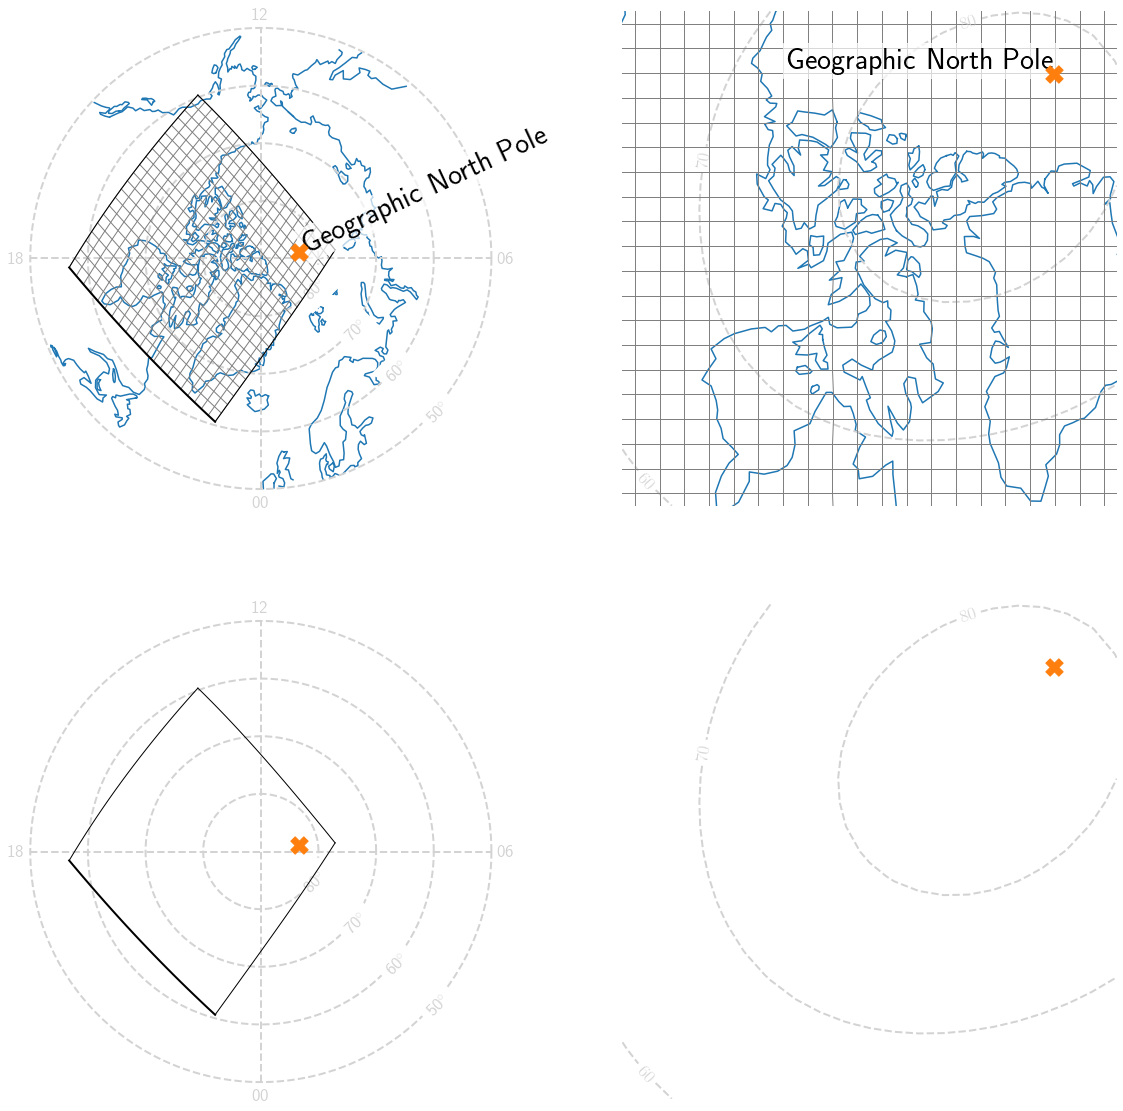

In [5]:
# on polar axis
a = apexpy.Apex(time, refh=0)             # to magnetic coordinates
mlat, mlon = a.geo2apex(90, 0, height=0)
mlt = a.mlon2mlt(mlon, time)
bboxdict = {'facecolor':'white', 'alpha':0.7, 'edgecolor':'white'}
scatdict = {'s':300, 'color':'C1', 'zorder':4, 'marker':'X'}
pax.text(  mlat, mlt, 'Geographic North Pole', fontsize=30, rotation=25, bbox=bboxdict)   # like plt.text
pax .scatter(mlat, mlt, **scatdict)                                                       # like plt.scatter
pax2.scatter(mlat, mlt, **scatdict)

# on xi, eta axis
xi, eta = grid.projection.geo2cube(0,90) # lon, lat, North pole
axs['grid'].text(   xi, eta, 'Geographic North Pole', fontsize=30, ha='right', va='bottom', bbox=bboxdict)
axs['grid' ].scatter(xi, eta, **scatdict)
axs['grid2'].scatter(xi, eta, **scatdict)

fig

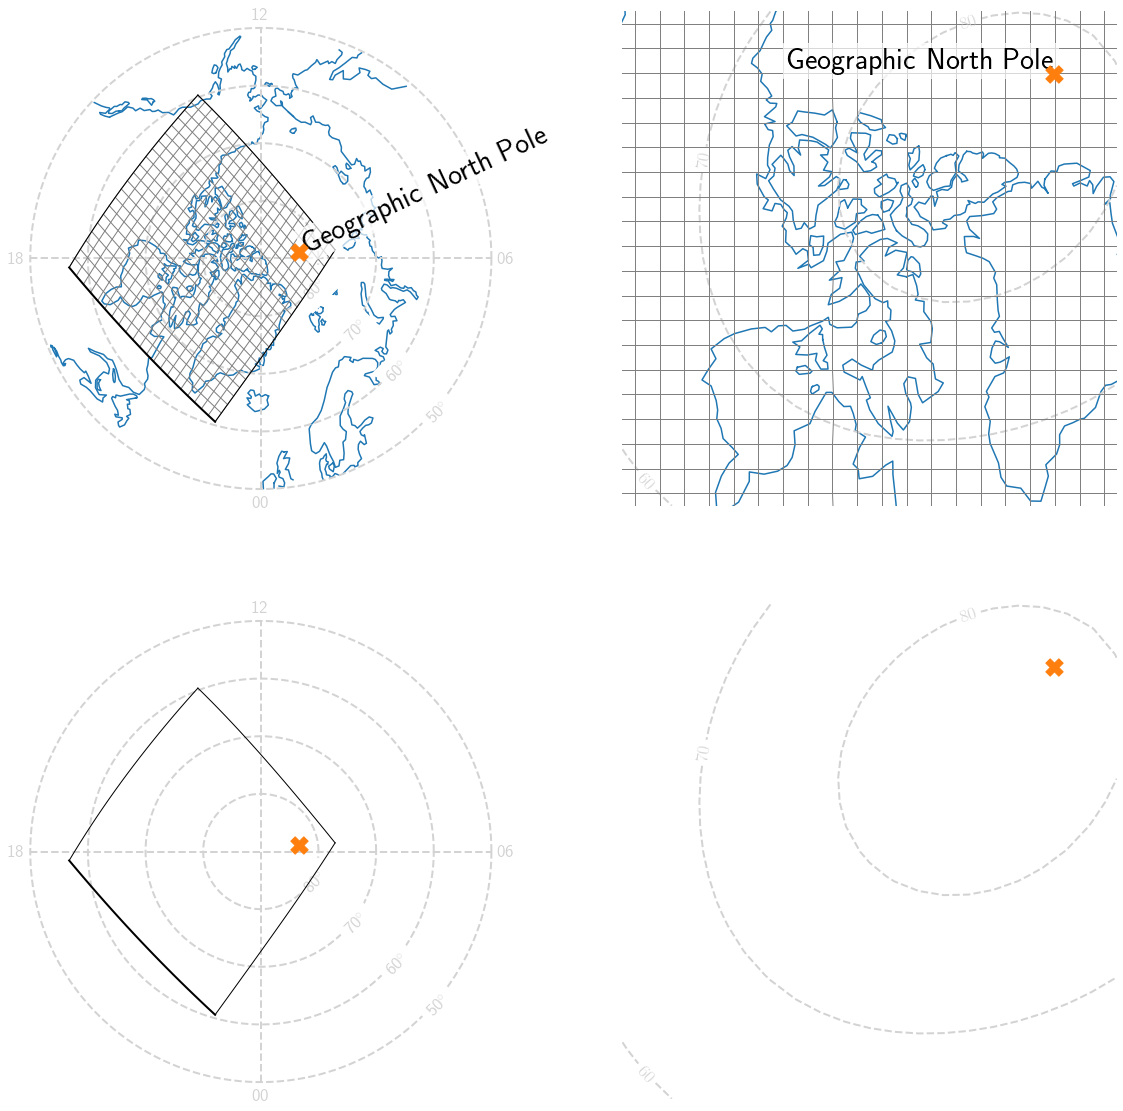

In [6]:
# TODO: terminator
#pax.plot_terminator(time, terminatorcolor='grey', shadecolor='grey')

fig

#### Contour

We can for instance plot the electric potential contours from the Weimer (2005) model:

In [7]:
# get Weimer potential
weimer = pd.read_table('./datasets/weimer.txt', sep=' ', skipinitialspace=True, comment='#', 
                       names=['mlat', 'mlt', 'R_E', 'phi'])
weimer = weimer[weimer.mlat > 50] # remove southern hemisphere
mlat   = weimer.mlat.values.reshape((181, 61))       # mlat
mlt    = weimer.mlt .values.reshape((181, 61))       # mlt
V      = weimer.phi .values.reshape((181, 61)) * 1e3 # kV to V

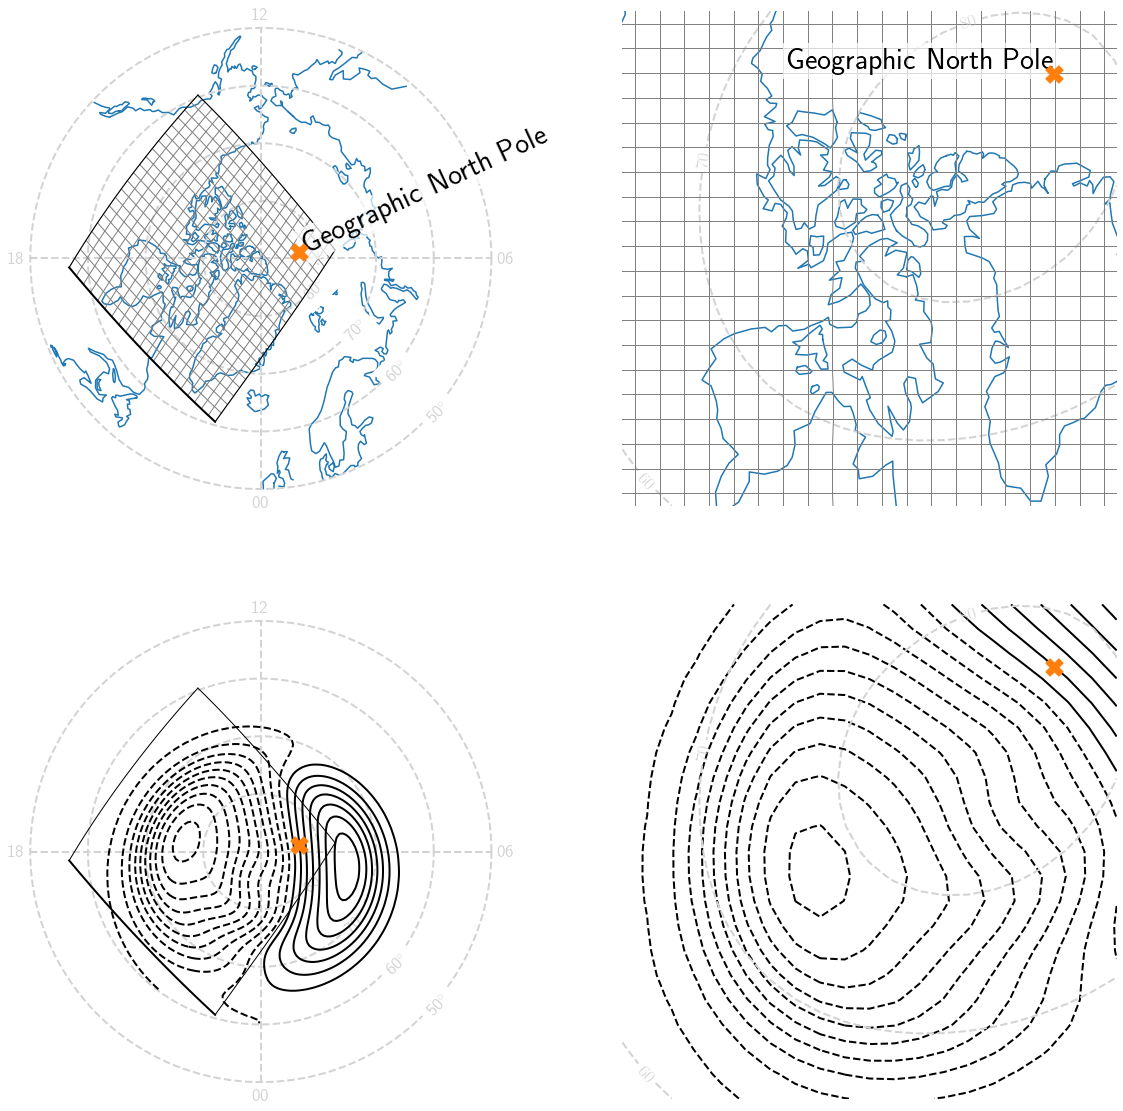

In [8]:
# on polar axis
pax2.contour(mlat, mlt, V, levels=np.r_[-101:101:4]*1e3, colors='black', linewidths=2)  # like plt.contour

# on xi, eta grid
a = apexpy.Apex(time, refh=110)          # to geographic coordinates
mlon = a.mlt2mlon(mlt, time)
lat, lon, _ = a.apex2geo(mlat, mlon, height=110)

# interpolate potential to CS grid 
xi, eta = grid.projection.geo2cube(lon, lat)
V       = griddata((xi.flatten(), eta.flatten()), V.flatten(), (grid.xi.flatten(), grid.eta.flatten()), 
                   fill_value = 0, method = 'cubic').reshape(grid.shape)
axs['grid2'].contour(grid.xi, grid.eta, V, levels=np.r_[-101:101:4]*1e3, colors='black', zorder=1, linewidths=2)
fig



#### Quiver

Vector fields or individual vectors can be plotted using quiver. An example of this is plotting the corotation veclocity, which is calculated based on geographic latitude:
\begin{equation}
    \mathbf{v}_{\mathrm{rot}}=\frac{\pi \mathrm{R_E}}{24\mathrm{\ hr}}\cos{\theta}
\end{equation}


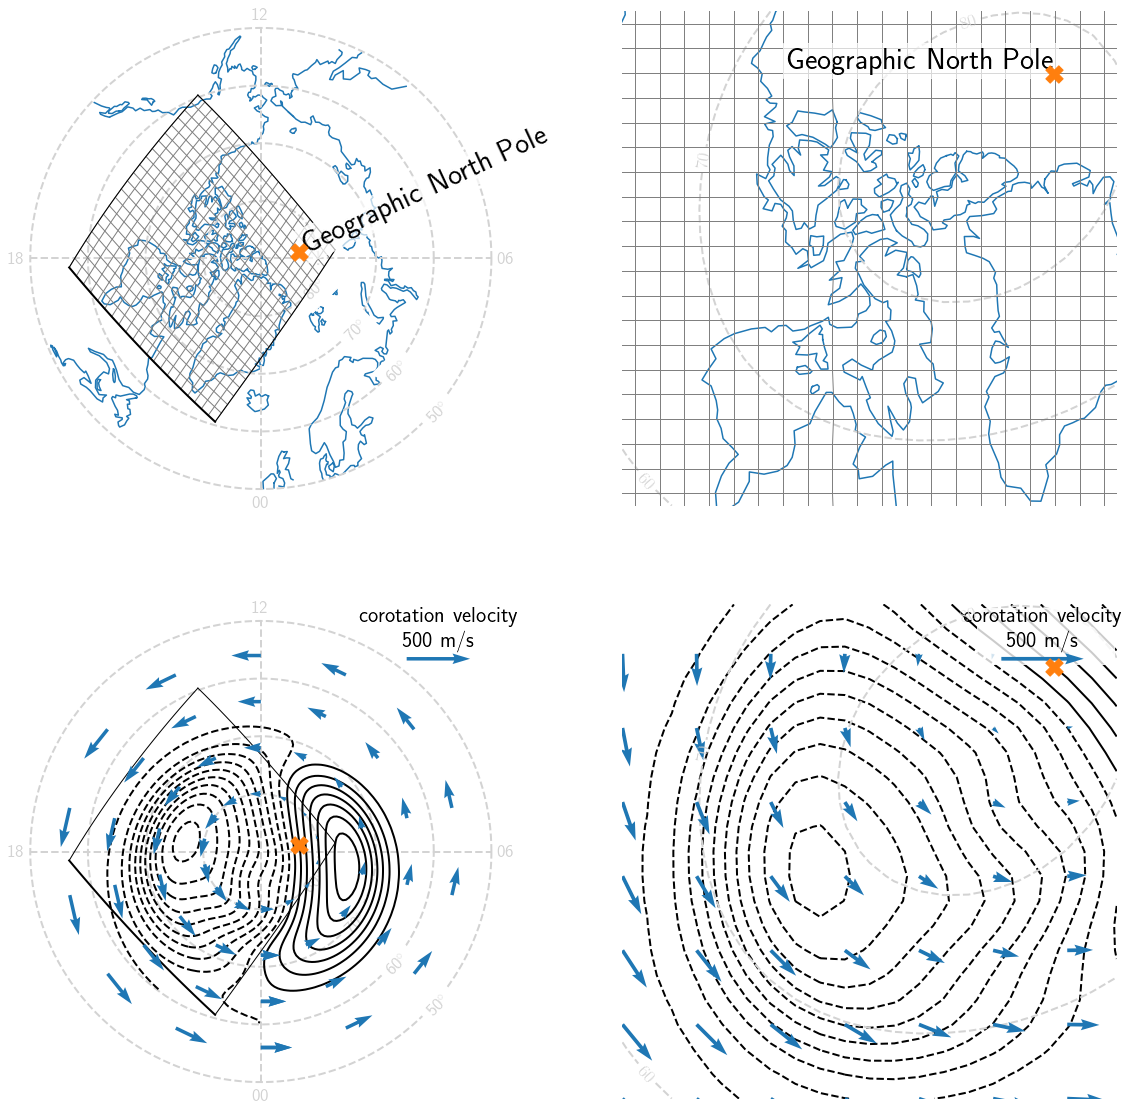

In [9]:
# on polar axis
mlats, mlts = np.meshgrid(np.linspace(48,80,5), np.linspace(0,24,15)) # grid of mlat and mlts
mlon = a.mlt2mlon(mlts, time)                 # to geographic
lats, _, _ = a.apex2geo(mlats, mlon, height=0)
v_e = Re * np.cos(lats * np.pi / 180) * 2 * np.pi / (24 * 60**2)   # corotation velocity
v_n = np.zeros((v_e.shape))

qkey = {'X':.85, 'Y':.89, 'U':500, 'label':'corotation velocity\n 500 m/s', 'labelpos':'N', 'fontproperties':{'size':22}, 'zorder':3} # quiver key
pax2.quiver(mlats, mlts, v_n, v_e, qkeyproperties=qkey, scale=4000, color='C0', zorder=2) # like plt.quiver

# xi, eta axis
v_e = Re * np.cos(grid.lat * np.pi / 180) * 2 * np.pi / (24 * 60**2) # corotation velocity
v_n = np.zeros((v_e.shape))
vxi, veta = grid.projection.vector_cube_projection(v_e.flatten(), v_n.flatten(), 
                                                   grid.lon.flatten(), grid.lat.flatten(), return_xi_eta=False)
vxi, veta = vxi.reshape(grid.shape), veta.reshape(grid.shape)
SKIP = 3
quiv = axs['grid2'].quiver(grid.xi[::SKIP, ::SKIP], grid.eta[::SKIP, ::SKIP], vxi[::SKIP, ::SKIP], 
                           veta[::SKIP, ::SKIP], scale = 3000, color = 'C0', zorder=3)
axs['grid2'].quiverkey(quiv, **qkey)
axs['grid2'].fill_between([.13,.3], [.23], [.3], edgecolor='face', color='white', zorder=3, alpha=.8)

fig 


#### Save plot

Finally, we do small adjustments to the plot and save it.

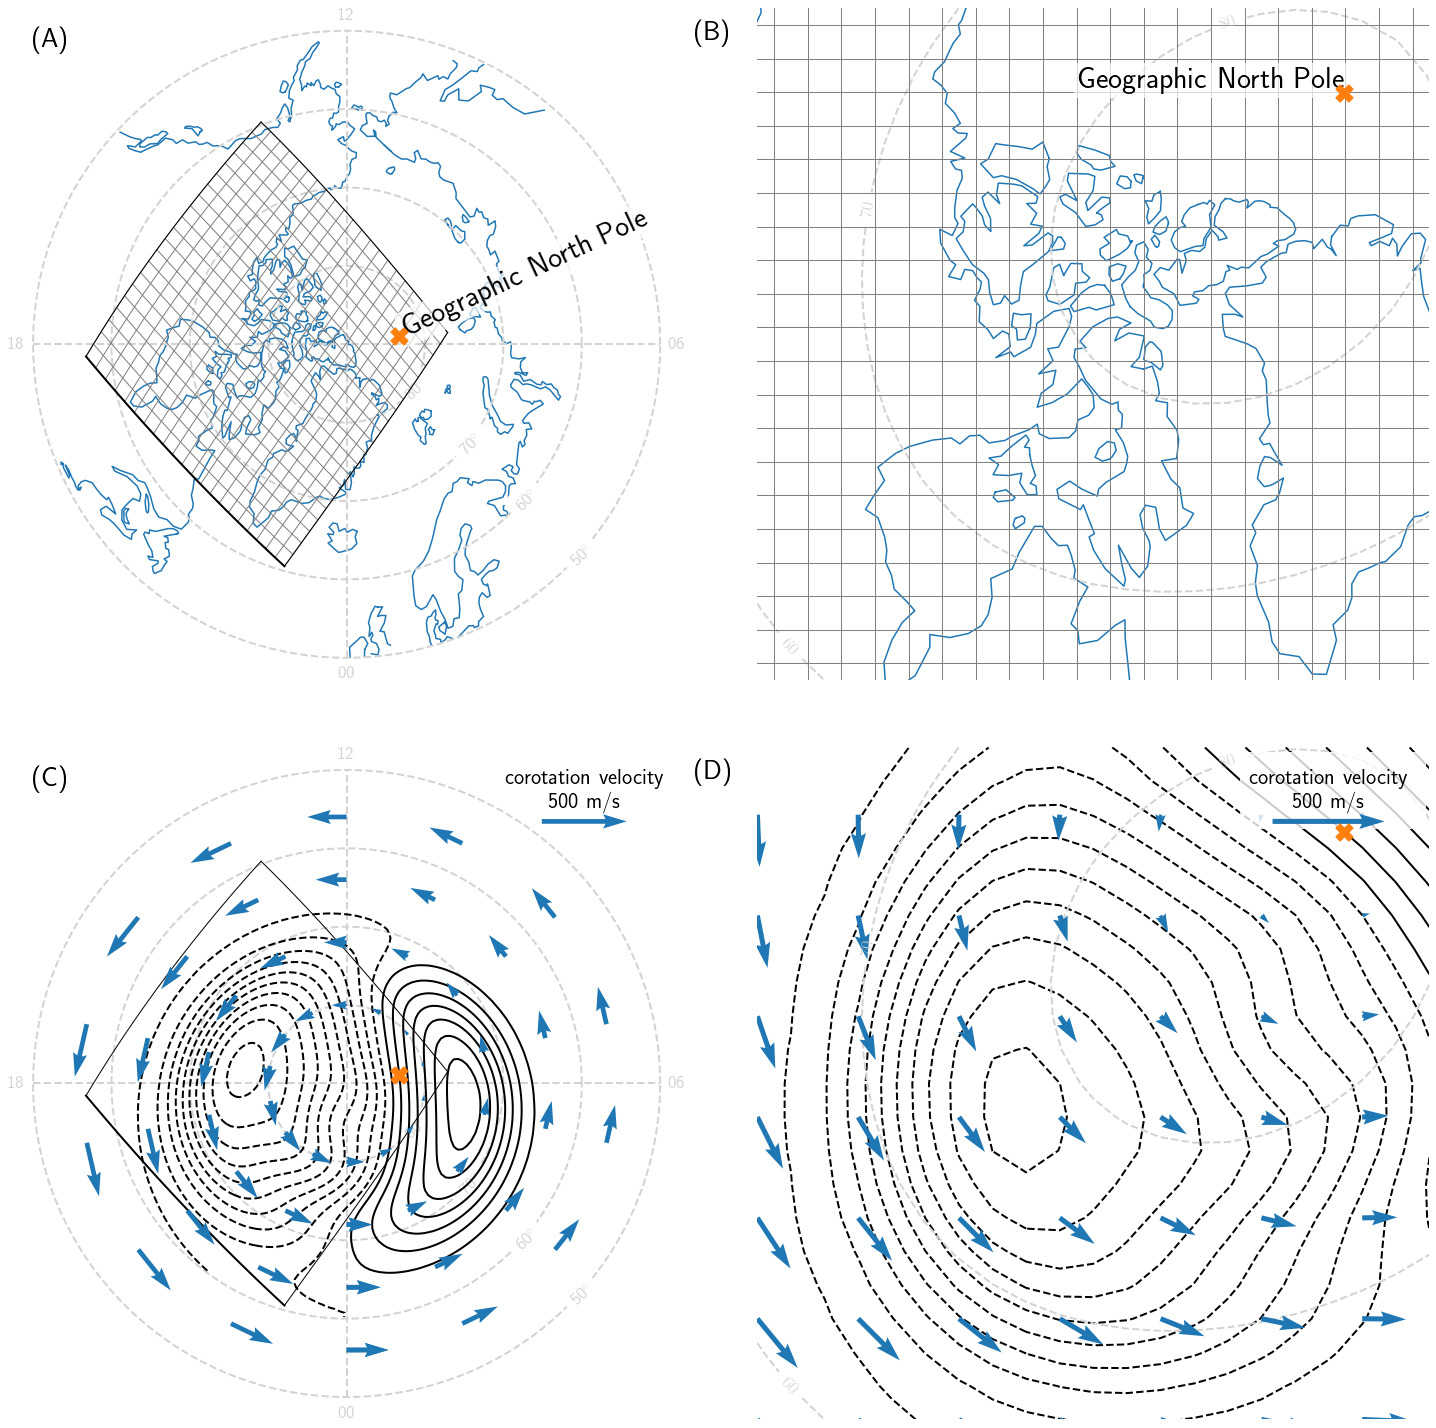

In [10]:
# add subfigure letters
axs['polar' ].text(-1,    0.95, '(A)', fontsize=28)
axs['grid'  ].text(-0.37, 0.275, '(B)', fontsize=28)
axs['polar2'].text(-1,    0.95, '(C)', fontsize=28)
axs['grid2' ].text(-0.37, 0.275, '(D)', fontsize=28)

fig.subplots_adjust(hspace=0.1, wspace=.1,left=0, right=.99, bottom=.01, top=.99)

# save figure
fig.savefig('./output_figures/Polarplotexample.png')
fig.savefig('./output_figures/Polarplotexample.pdf')
fig

The panels show:
- (A) A cubed sphere grid on a MLAT/MLT axis. The thick line corresponds to the bottom of the grid to the right. The orange cross marks the Geographic North Pole.
- (B) The cubed sphere grid as plotted in (A). The same parameters are shown, but in the cubed sphere $\xi, \eta$ coordinate system.
- (C) Same axis as in (A), but without coastlines. The orange cross still marks the Geographic North Pole. Electric potential contours from the Weimer (2005) model is shown in black. The blue arrows show the corotation velocity of the Earth as it rotates below the magnetic latitude/MLT axis.
- (D) The same parameters as in (C), but in cubed sphere $\xi, \eta$ coordinates.
   
    